In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
REWARD = 100

In [5]:
seed = 9295
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 1 #pole length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  VBKG0BIX_01_48_22
NN-MODEL FILENAME:  ./models/VBKG0BIX_01_48_22_NN.pt


In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val, length_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s  , length_s     = borders
    
    indx = np.empty_like(value).astype(np.uint)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax()
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.uint)
    return indx



In [9]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [10]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 500   # target update frequency
MIN_MEMORY_CAP      = 200000

In [11]:
MAX_NO_OF_ITERATIONS = 50
MAX_NN_ITERATIONS    = 50000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  50


In [12]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action
    
    def get_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions = self.eval_net.forward(x).view(-1,N_ACTIONS).max(1)[1].data.numpy().astype(np.intp)
#         actions_value 
#         action = torch.max(actions_value, 1)[1].data.numpy()
#         action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return actions
    
    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [13]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [14]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.6
C_POS_ABS_MIN = -2.6

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

LENGTH_ABS_MAX = 0.725
LENGTH_ABS_MIN = 0.275

In [15]:
# SET GRANULARITY
HI_GRAIN = 40
LO_GRAIN = 4
print("HI_GRAIN = ", HI_GRAIN)
print("LO_GRAIN = ", LO_GRAIN)

HI_GRAIN =  40
LO_GRAIN =  4


In [16]:
def mp_node_run(node_id, boundary, iteration, node_q_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################
     # Mean values of pole length deviate from original value
    scaling_factor = 0.4 + (1.4 - 0.4) * (node_id + 1)/(NO_OF_NODES)
    ORIGNAL_LENGTH = 0.5    
    length_mean    = ORIGNAL_LENGTH * scaling_factor

    LENGTH_MAX = length_mean + 0.025
    LENGTH_MIN = length_mean - 0.025

    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_ABS_MIN,  C_POS_ABS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_ABS_MIN,  C_VEL_ABS_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_ABS_MIN,  P_ANG_ABS_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_ABS_MIN,  P_VEL_ABS_MAX,  HI_GRAIN)
    length_s = np.linspace(LENGTH_MIN,     LENGTH_MAX,     LO_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s, length_s]
    ###############################################
    
    my_Q_TABLE = node_q_table[:,:,:,:, int(node_id*LO_GRAIN):int((node_id+1)*LO_GRAIN)]

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((3%5 + 1)*0.1 + (iteration)*0.2) ,0.4,0.98)+ np.random.uniform(-0.01,0.01)
#     print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            my_env.length   = length_mean + np.random.uniform(-0.025,0.025)
            xtra = [my_env.length]
            
            s = my_env.reset()
            s = np.append(s, xtra)
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state]

                 # take action
                s_, r, done, info = my_env.step(a)
                s_ = np.append(s_, xtra)

                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX ] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN ] = [exp_rec[:,i].min() for i in range(N_STATES)]

    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]
    
    return exp_rec, time_rec, newboundary

In [17]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [18]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN*NO_OF_NODES   ])



# # GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN,LO_GRAIN*NO_OF_NODES).astype(np.intp)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 47724.34 MiB, increment: 43675.48 MiB
Quantization TIME:  0.41 minutes


In [19]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table



ITERATION # 0
TOTAL EXPERIENCE GENERATED:   41176
SMALLEST TIMESTEP: 8
LARGEST  TIMESTEP: 136
TOTAL SERIAL TIMESTEPS:   41176
TOTAL PARALLEL TIMESTEPS: 136


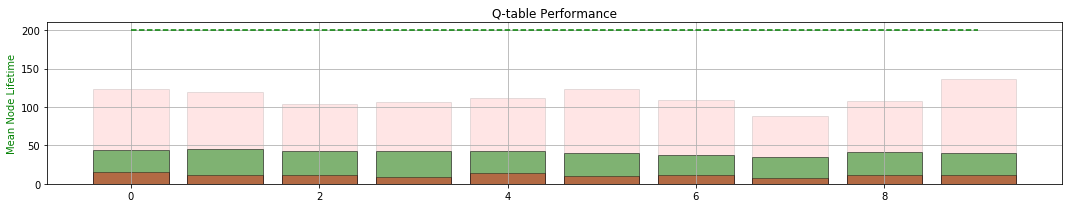

MEMORY COUNTER:  41176
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 219.995	LOSS : 228.449	LOSS : 230.682	LOSS : 233.478	LOSS : 227.310	LOSS : 218.581	LOSS : 215.684	LOSS : 212.976	LOSS : 213.563	LOSS : 230.682	LOSS : 213.991	LOSS : 217.329	LOSS : 213.087	LOSS : 216.641	LOSS : 231.153	LOSS : 210.380	LOSS : 207.958	LOSS : 203.139	LOSS : 215.176	LOSS : 197.026	
Validating... MEAN TIME:  200.0
LOSS : 210.193	LOSS : 206.315	LOSS : 213.936	LOSS : 204.809	LOSS : 199.255	LOSS : 196.821	LOSS : 218.804	LOSS : 204.362	LOSS : 202.288	LOSS : 200.437	LOSS : 200.963	LOSS : 211.896	LOSS : 204.195	LOSS : 197.032	LOSS : 192.034	LOSS : 203.927	LOSS : 209.765	LOSS : 205.201	LOSS : 211.162	LOSS : 207.991	
Validating... MEAN TIME:  197.735
LOSS : 208.766	LOSS : 198.883	LOSS : 193.292	LOSS : 220.057	LOSS : 195.425	LOSS : 214.884	LOSS : 200.764	LOSS : 204.828	LOSS : 203.508	LOSS : 210.318	LOSS : 201.506	LOSS : 208.896	LOSS : 209.946	LOSS : 200.507	LOSS : 209.413	LOSS : 203.046	LOSS : 205

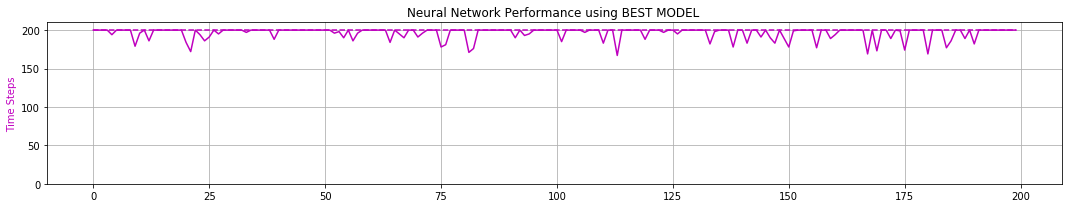

peak memory: 48618.32 MiB, increment: 43745.19 MiB
0 -max- [ 0.874  1.863  0.208  1.727  0.275]
0 -min- [-0.693 -1.354 -0.209 -2.044  0.225]

1 -max- [ 1.036  1.863  0.207  2.127  0.325]
1 -min- [-0.862 -1.509 -0.209 -2.196  0.275]

2 -max- [ 0.973  1.942  0.208  1.867  0.375]
2 -min- [-0.695 -1.475 -0.209 -2.260  0.325]

3 -max- [ 1.066  2.236  0.209  1.704  0.425]
3 -min- [-1.046 -1.868 -0.209 -1.962  0.375]

4 -max- [ 0.964  2.278  0.209  1.767  0.475]
4 -min- [-0.812 -1.318 -0.209 -1.990  0.425]

5 -max- [ 1.210  2.100  0.209  1.527  0.525]
5 -min- [-0.490 -1.285 -0.209 -2.218  0.476]

6 -max- [ 1.250  2.662  0.208  1.835  0.574]
6 -min- [-1.307 -1.829 -0.209 -2.222  0.525]

7 -max- [ 1.152  2.048  0.206  2.026  0.625]
7 -min- [-0.475 -1.765 -0.209 -2.194  0.576]

8 -max- [ 0.875  2.305  0.209  2.231  0.675]
8 -min- [-0.567 -1.880 -0.209 -2.176  0.626]

9 -max- [ 1.003  2.139  0.208  1.968  0.725]
9 -min- [-0.258 -1.144 -0.209 -2.238  0.675]

Quantization TIME:  0.41 minutes


ITER

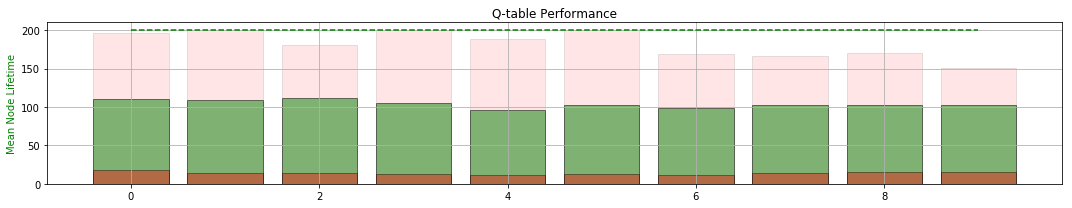

MEMORY COUNTER:  145448
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 131.488	LOSS : 129.342	LOSS : 113.992	LOSS : 125.511	LOSS : 123.776	LOSS : 119.860	LOSS : 124.287	LOSS : 125.702	LOSS : 125.203	LOSS : 117.328	LOSS : 119.703	LOSS : 126.065	LOSS : 121.365	LOSS : 128.257	LOSS : 120.878	LOSS : 125.668	LOSS : 119.220	LOSS : 119.504	LOSS : 123.153	LOSS : 122.865	
Validating... MEAN TIME:  128.775
LOSS : 122.390	LOSS : 109.246	LOSS : 120.593	LOSS : 123.463	LOSS : 123.630	LOSS : 111.152	LOSS : 126.278	LOSS : 109.470	LOSS : 115.211	LOSS : 117.312	LOSS : 123.332	LOSS : 124.640	LOSS : 123.556	LOSS : 122.426	LOSS : 127.439	LOSS : 116.128	LOSS : 111.679	LOSS : 127.579	LOSS : 117.168	LOSS : 131.237	
Validating... MEAN TIME:  144.17
LOSS : 122.314	LOSS : 115.253	LOSS : 118.170	LOSS : 111.084	LOSS : 121.129	LOSS : 120.889	LOSS : 133.279	LOSS : 113.757	LOSS : 117.632	LOSS : 112.071	LOSS : 116.300	LOSS : 123.789	LOSS : 125.879	LOSS : 119.792	LOSS : 117.011	LOSS : 136.559	LOSS : 1

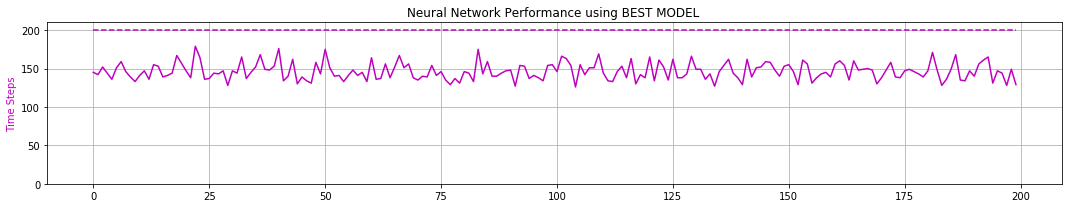

peak memory: 49284.18 MiB, increment: 43598.43 MiB
0 -max- [ 2.376  2.175  0.209  1.782  0.274]
0 -min- [-2.398 -2.975 -0.209 -2.030  0.225]

1 -max- [ 0.161  1.159  0.202  1.513  0.325]
1 -min- [-2.397 -2.777 -0.209 -1.766  0.275]

2 -max- [ 1.302  1.566  0.201  1.542  0.375]
2 -min- [-2.400 -2.940 -0.209 -1.884  0.325]

3 -max- [ 0.735  2.077  0.173  1.494  0.425]
3 -min- [-2.398 -3.326 -0.209 -2.677  0.375]

4 -max- [ 0.245  1.216  0.195  1.714  0.475]
4 -min- [-2.395 -2.760 -0.209 -2.219  0.425]

5 -max- [ 0.188  1.193  0.199  2.138  0.524]
5 -min- [-2.399 -2.803 -0.209 -1.824  0.477]

6 -max- [ 0.239  1.207  0.209  1.703  0.573]
6 -min- [-2.399 -2.922 -0.209 -2.331  0.525]

7 -max- [ 0.255  1.779  0.195  1.512  0.625]
7 -min- [-2.400 -3.002 -0.209 -2.331  0.575]

8 -max- [ 0.227  1.025  0.206  1.457  0.675]
8 -min- [-2.400 -2.990 -0.209 -1.772  0.625]

9 -max- [ 0.382  1.377  0.207  1.729  0.725]
9 -min- [-2.390 -2.917 -0.209 -1.930  0.675]

Quantization TIME:  0.41 minutes


ITER

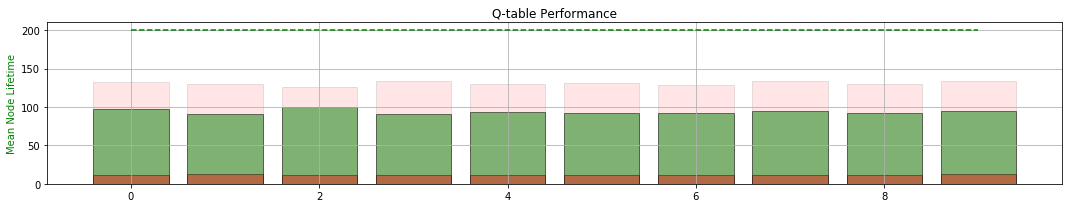

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 108.604	LOSS : 97.120	LOSS : 104.806	LOSS : 98.994	LOSS : 95.785	LOSS : 101.065	LOSS : 103.256	LOSS : 104.742	LOSS : 99.995	LOSS : 97.982	LOSS : 91.360	LOSS : 99.545	LOSS : 104.878	LOSS : 98.222	LOSS : 102.468	LOSS : 98.860	LOSS : 98.632	LOSS : 97.888	LOSS : 95.598	LOSS : 105.285	
Validating... MEAN TIME:  112.65
LOSS : 95.006	LOSS : 96.101	LOSS : 98.452	LOSS : 99.946	LOSS : 84.602	LOSS : 104.375	LOSS : 85.748	LOSS : 95.914	LOSS : 98.748	LOSS : 100.562	LOSS : 100.617	LOSS : 100.626	LOSS : 105.270	LOSS : 86.567	LOSS : 95.693	LOSS : 89.926	LOSS : 107.149	LOSS : 95.231	LOSS : 91.566	LOSS : 85.137	
Validating... MEAN TIME:  129.465
LOSS : 94.094	LOSS : 97.805	LOSS : 89.835	LOSS : 100.909	LOSS : 95.734	LOSS : 96.753	LOSS : 93.812	LOSS : 102.695	LOSS : 88.163	LOSS : 95.538	LOSS : 88.201	LOSS : 102.512	LOSS : 96.988	LOSS : 94.487	LOSS : 103.260	LOSS : 90.423	LOSS : 98.621	LOSS : 99.248	LOSS : 88.525	LOSS

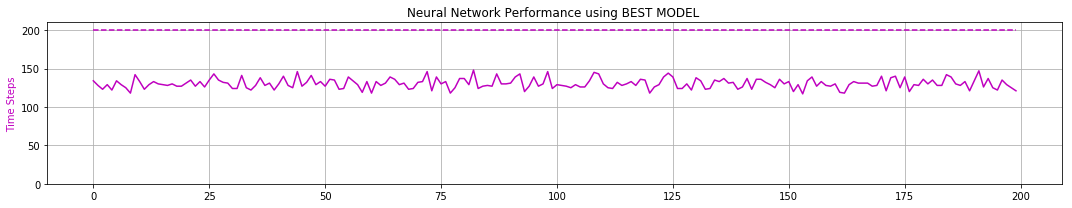

peak memory: 49418.29 MiB, increment: 43707.51 MiB
0 -max- [ 0.197  1.017  0.071  1.381  0.274]
0 -min- [-2.400 -2.953 -0.209 -1.746  0.225]

1 -max- [ 0.172  1.177  0.057  1.445  0.325]
1 -min- [-2.400 -2.983 -0.209 -1.620  0.275]

2 -max- [ 0.177  1.034  0.050  1.206  0.375]
2 -min- [-2.397 -3.089 -0.209 -1.909  0.325]

3 -max- [ 0.211  0.998  0.053  1.304  0.424]
3 -min- [-2.400 -2.950 -0.209 -1.627  0.376]

4 -max- [ 0.215  1.217  0.056  1.437  0.475]
4 -min- [-2.396 -2.926 -0.209 -1.957  0.425]

5 -max- [ 0.181  0.990  0.046  1.373  0.525]
5 -min- [-2.399 -2.951 -0.209 -1.745  0.475]

6 -max- [ 0.172  1.012  0.048  1.498  0.575]
6 -min- [-2.397 -3.088 -0.209 -1.734  0.526]

7 -max- [ 0.173  0.997  0.074  1.220  0.624]
7 -min- [-2.400 -3.103 -0.209 -1.613  0.576]

8 -max- [ 0.203  1.187  0.203  1.254  0.674]
8 -min- [-2.400 -2.964 -0.209 -1.958  0.625]

9 -max- [ 0.180  1.005  0.162  1.789  0.723]
9 -min- [-2.400 -3.279 -0.209 -1.812  0.675]

Quantization TIME:  0.41 minutes


ITER

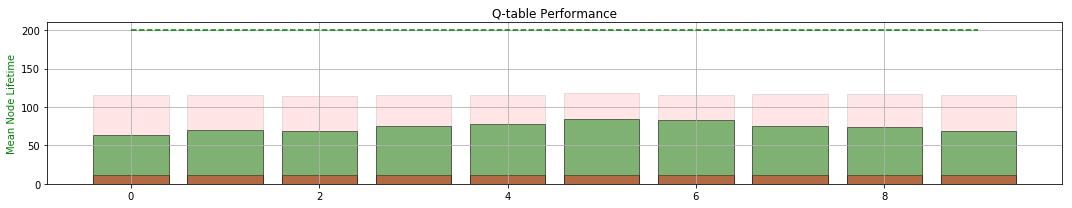

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 110.243	LOSS : 126.639	LOSS : 105.399	LOSS : 108.130	LOSS : 103.141	LOSS : 118.620	LOSS : 109.702	LOSS : 107.986	LOSS : 97.905	LOSS : 97.466	LOSS : 92.152	LOSS : 103.139	LOSS : 104.461	LOSS : 104.710	LOSS : 110.053	LOSS : 100.536	LOSS : 97.734	LOSS : 105.002	LOSS : 97.391	LOSS : 104.778	
Validating... MEAN TIME:  104.96
LOSS : 110.079	LOSS : 108.152	LOSS : 105.954	LOSS : 97.558	LOSS : 102.646	LOSS : 98.865	LOSS : 101.295	LOSS : 111.541	LOSS : 115.291	LOSS : 114.792	LOSS : 102.858	LOSS : 115.791	LOSS : 118.987	LOSS : 123.593	LOSS : 105.802	LOSS : 126.183	LOSS : 110.061	LOSS : 113.380	LOSS : 113.013	LOSS : 112.900	
Validating... MEAN TIME:  114.84
LOSS : 98.755	LOSS : 111.785	LOSS : 104.747	LOSS : 96.776	LOSS : 99.203	LOSS : 99.195	LOSS : 109.800	LOSS : 99.573	LOSS : 103.394	LOSS : 101.466	LOSS : 102.958	LOSS : 101.705	LOSS : 123.118	LOSS : 104.399	LOSS : 98.427	LOSS : 109.018	LOSS : 105.340	LOSS : 

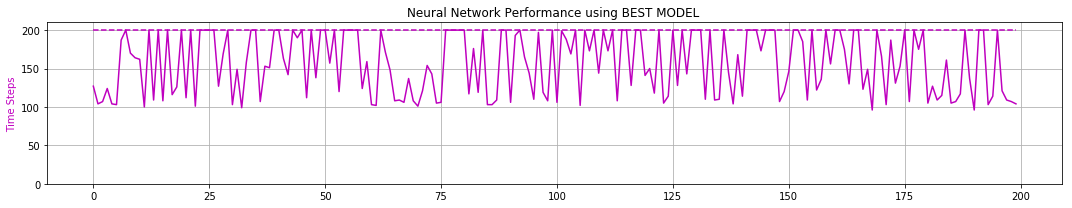

peak memory: 49247.04 MiB, increment: 43548.16 MiB
0 -max- [ 0.187  1.179  0.101  1.486  0.274]
0 -min- [-2.398 -3.182 -0.209 -1.674  0.225]

1 -max- [ 0.202  1.201  0.094  1.408  0.325]
1 -min- [-2.400 -2.965 -0.209 -1.691  0.276]

2 -max- [ 0.212  1.205  0.096  1.623  0.375]
2 -min- [-2.400 -3.198 -0.209 -1.753  0.325]

3 -max- [ 0.199  1.174  0.102  1.579  0.425]
3 -min- [-2.399 -3.206 -0.209 -1.663  0.376]

4 -max- [ 0.206  1.208  0.107  1.596  0.475]
4 -min- [-2.399 -3.207 -0.209 -1.737  0.425]

5 -max- [ 0.199  1.209  0.087  1.583  0.525]
5 -min- [-2.400 -3.207 -0.209 -1.681  0.475]

6 -max- [ 0.205  1.205  0.091  1.846  0.575]
6 -min- [-2.400 -3.389 -0.209 -1.673  0.525]

7 -max- [ 0.219  1.204  0.095  1.794  0.625]
7 -min- [-2.400 -3.560 -0.209 -1.680  0.575]

8 -max- [ 0.222  1.193  0.071  1.634  0.675]
8 -min- [-2.399 -3.362 -0.209 -1.672  0.625]

9 -max- [ 0.205  1.215  0.083  1.650  0.724]
9 -min- [-2.399 -3.391 -0.209 -1.676  0.675]

Quantization TIME:  0.41 minutes


ITER

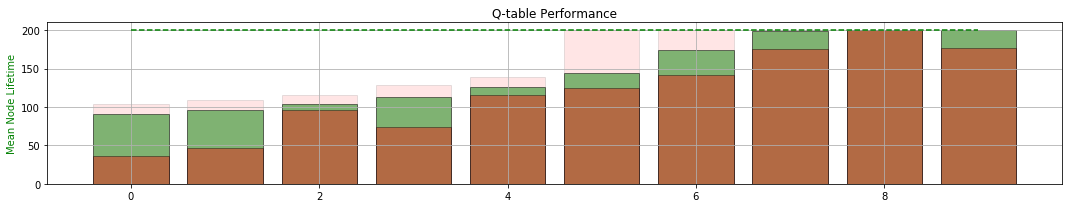

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 99.985	LOSS : 91.769	LOSS : 93.889	LOSS : 87.512	LOSS : 96.711	LOSS : 105.448	LOSS : 90.829	LOSS : 96.450	LOSS : 80.003	LOSS : 84.493	LOSS : 84.358	LOSS : 91.882	LOSS : 79.615	LOSS : 93.162	LOSS : 82.509	LOSS : 90.759	LOSS : 83.019	LOSS : 89.173	LOSS : 95.556	LOSS : 97.483	
Validating... MEAN TIME:  106.98
LOSS : 96.967	LOSS : 88.559	LOSS : 84.269	LOSS : 90.385	LOSS : 84.937	LOSS : 83.885	LOSS : 78.155	LOSS : 88.843	LOSS : 92.175	LOSS : 90.594	LOSS : 93.783	LOSS : 83.896	LOSS : 88.825	LOSS : 89.109	LOSS : 94.098	LOSS : 81.424	LOSS : 92.387	LOSS : 86.146	LOSS : 90.075	LOSS : 82.710	
Validating... MEAN TIME:  148.13
LOSS : 76.357	LOSS : 84.114	LOSS : 80.026	LOSS : 84.228	LOSS : 80.071	LOSS : 90.147	LOSS : 82.140	LOSS : 81.967	LOSS : 81.877	LOSS : 82.180	LOSS : 73.296	LOSS : 78.680	LOSS : 82.724	LOSS : 78.983	LOSS : 82.353	LOSS : 81.742	LOSS : 78.426	LOSS : 72.889	LOSS : 68.854	LOSS : 82.939	
Validat

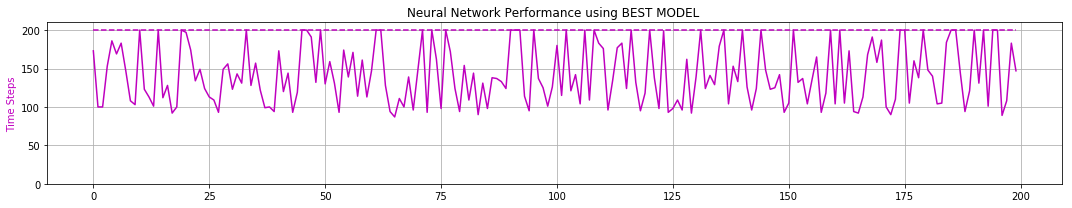

peak memory: 48971.47 MiB, increment: 43224.28 MiB
0 -max- [ 0.161  0.825  0.047  1.013  0.275]
0 -min- [-2.400 -3.458 -0.209 -1.144  0.225]

1 -max- [ 0.178  0.827  0.048  1.100  0.325]
1 -min- [-2.399 -3.665 -0.209 -1.201  0.275]

2 -max- [ 0.148  0.738  0.048  0.910  0.374]
2 -min- [-2.400 -3.333 -0.209 -1.198  0.325]

3 -max- [ 0.152  0.623  0.046  0.915  0.425]
3 -min- [-2.399 -3.340 -0.208 -1.042  0.376]

4 -max- [ 0.144  0.536  0.048  0.952  0.475]
4 -min- [-2.400 -3.110 -0.207 -1.094  0.425]

5 -max- [ 0.184  0.439  0.049  0.797  0.525]
5 -min- [-2.400 -2.930 -0.205 -1.250  0.475]

6 -max- [ 0.190  0.549  0.049  0.686  0.574]
6 -min- [-2.399 -2.789 -0.209 -1.051  0.525]

7 -max- [ 0.554  0.557  0.050  0.700  0.625]
7 -min- [-2.398 -2.603 -0.205 -1.043  0.575]

8 -max- [ 1.397  1.248  0.071  0.928  0.674]
8 -min- [-1.096 -1.608 -0.161 -1.016  0.625]

9 -max- [ 2.382  1.633  0.089  0.674  0.724]
9 -min- [-0.192 -1.290 -0.168 -1.019  0.675]

Quantization TIME:  0.4 minutes


ITERA

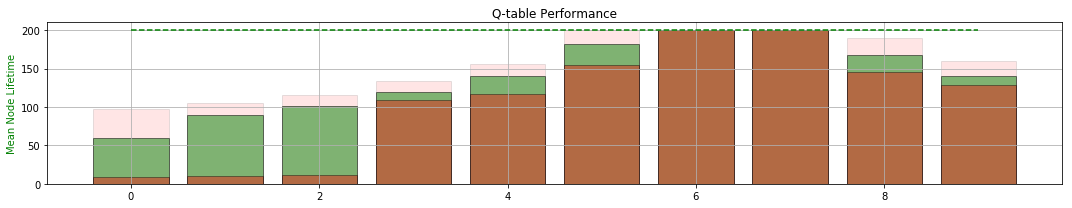

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 68.025	LOSS : 76.512	LOSS : 80.378	LOSS : 67.889	LOSS : 73.981	LOSS : 76.717	LOSS : 68.902	LOSS : 70.916	LOSS : 74.391	LOSS : 67.233	LOSS : 79.864	LOSS : 85.074	LOSS : 82.297	LOSS : 65.391	LOSS : 78.395	LOSS : 71.977	LOSS : 78.804	LOSS : 75.771	LOSS : 78.850	LOSS : 72.523	
Validating... MEAN TIME:  122.25
LOSS : 68.636	LOSS : 72.315	LOSS : 67.685	LOSS : 65.724	LOSS : 65.970	LOSS : 71.012	LOSS : 73.649	LOSS : 65.826	LOSS : 66.645	LOSS : 75.058	LOSS : 68.283	LOSS : 72.862	LOSS : 71.597	LOSS : 75.614	LOSS : 71.579	LOSS : 70.382	LOSS : 79.436	LOSS : 75.991	LOSS : 67.690	LOSS : 74.904	
Validating... MEAN TIME:  200.0
LOSS : 74.078	LOSS : 73.232	LOSS : 66.122	LOSS : 68.511	LOSS : 72.241	LOSS : 62.387	LOSS : 67.082	LOSS : 63.688	LOSS : 62.113	LOSS : 80.894	LOSS : 72.245	LOSS : 66.923	LOSS : 64.879	LOSS : 66.774	LOSS : 63.965	LOSS : 59.591	LOSS : 71.142	LOSS : 71.741	LOSS : 66.506	LOSS : 70.145	
Validatin

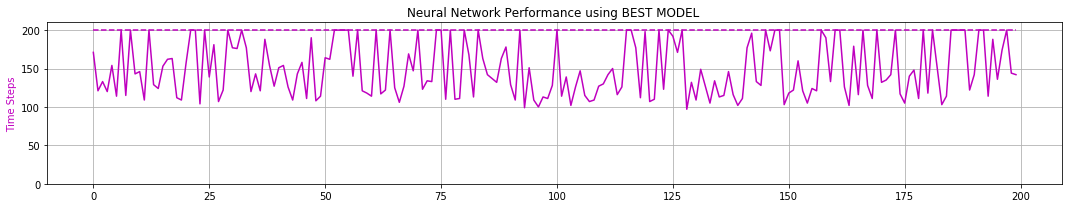

peak memory: 48831.63 MiB, increment: 43082.43 MiB
0 -max- [ 0.221  1.400  0.048  1.116  0.275]
0 -min- [-2.398 -3.664 -0.209 -1.991  0.225]

1 -max- [ 0.196  1.400  0.048  1.090  0.325]
1 -min- [-2.399 -3.326 -0.208 -2.064  0.275]

2 -max- [ 0.214  1.341  0.046  1.167  0.373]
2 -min- [-2.399 -3.178 -0.209 -1.986  0.325]

3 -max- [ 0.183  1.202  0.048  1.164  0.425]
3 -min- [-2.400 -2.917 -0.208 -1.684  0.376]

4 -max- [ 0.143  1.020  0.049  1.225  0.474]
4 -min- [-2.400 -3.151 -0.208 -1.449  0.425]

5 -max- [ 0.111  0.824  0.049  1.027  0.524]
5 -min- [-2.399 -2.756 -0.186 -1.301  0.475]

6 -max- [ 0.449  0.803  0.049  0.912  0.574]
6 -min- [-1.437 -1.334 -0.140 -1.074  0.526]

7 -max- [ 2.144  1.310  0.070  0.883  0.624]
7 -min- [-0.116 -0.625 -0.049 -0.901  0.575]

8 -max- [ 2.399  2.062  0.084  1.144  0.674]
8 -min- [-0.105 -0.794 -0.049 -0.928  0.625]

9 -max- [ 2.400  2.262  0.143  1.204  0.725]
9 -min- [-0.138 -0.758 -0.048 -1.077  0.675]

Quantization TIME:  0.39 minutes


ITER

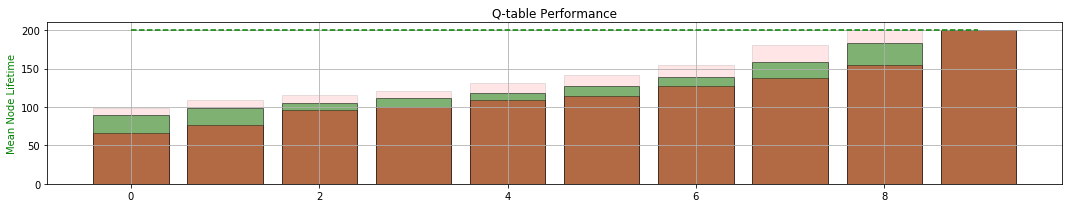

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 66.882	LOSS : 58.808	LOSS : 61.388	LOSS : 68.790	LOSS : 62.671	LOSS : 69.207	LOSS : 65.727	LOSS : 67.771	LOSS : 61.570	LOSS : 71.903	LOSS : 74.070	LOSS : 62.928	LOSS : 65.813	LOSS : 61.967	LOSS : 68.620	LOSS : 55.905	LOSS : 66.346	LOSS : 72.448	LOSS : 66.245	LOSS : 64.900	
Validating... MEAN TIME:  154.395
LOSS : 63.903	LOSS : 63.539	LOSS : 66.151	LOSS : 63.226	LOSS : 61.835	LOSS : 57.135	LOSS : 63.874	LOSS : 68.733	LOSS : 62.484	LOSS : 69.730	LOSS : 61.517	LOSS : 61.820	LOSS : 62.119	LOSS : 66.259	LOSS : 60.496	LOSS : 59.036	LOSS : 72.846	LOSS : 62.644	LOSS : 70.492	LOSS : 65.495	
Validating... MEAN TIME:  119.42
LOSS : 70.331	LOSS : 67.460	LOSS : 68.880	LOSS : 70.791	LOSS : 71.182	LOSS : 71.871	LOSS : 64.595	LOSS : 72.388	LOSS : 63.878	LOSS : 63.891	LOSS : 68.370	LOSS : 65.289	LOSS : 74.785	LOSS : 70.165	LOSS : 76.462	LOSS : 75.773	LOSS : 77.449	LOSS : 69.973	LOSS : 68.818	LOSS : 66.123	
Validat

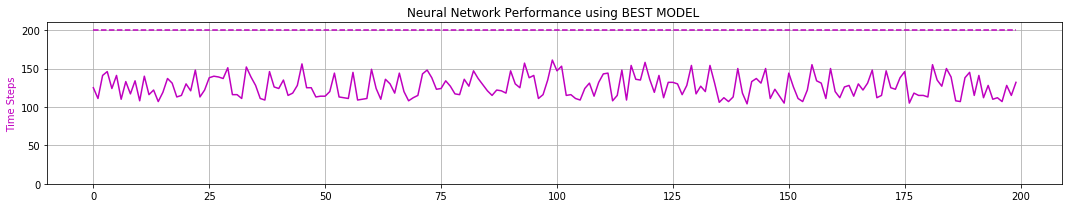

peak memory: 49344.18 MiB, increment: 43564.23 MiB
0 -max- [ 0.167  1.023  0.048  0.638  0.275]
0 -min- [-2.151 -2.894 -0.209 -1.521  0.225]

1 -max- [ 0.163  1.013  0.046  0.764  0.325]
1 -min- [-2.244 -2.989 -0.209 -1.485  0.275]

2 -max- [ 0.148  0.823  0.048  0.604  0.374]
2 -min- [-2.182 -2.688 -0.209 -1.205  0.326]

3 -max- [ 0.148  1.004  0.049  0.840  0.425]
3 -min- [-2.315 -2.549 -0.209 -1.416  0.376]

4 -max- [ 0.126  0.824  0.049  0.868  0.475]
4 -min- [-2.258 -2.377 -0.209 -1.187  0.425]

5 -max- [ 0.159  0.810  0.057  0.774  0.525]
5 -min- [-2.326 -2.342 -0.209 -1.171  0.476]

6 -max- [ 0.136  0.825  0.050  0.785  0.575]
6 -min- [-2.200 -2.139 -0.209 -1.258  0.526]

7 -max- [ 0.161  0.634  0.048  0.908  0.625]
7 -min- [-2.249 -1.998 -0.209 -1.043  0.575]

8 -max- [ 0.104  0.750  0.054  0.707  0.674]
8 -min- [-2.290 -2.019 -0.209 -1.086  0.626]

9 -max- [ 0.150  0.631  0.051  0.727  0.725]
9 -min- [-2.079 -1.667 -0.207 -0.910  0.675]

Quantization TIME:  0.39 minutes


ITER

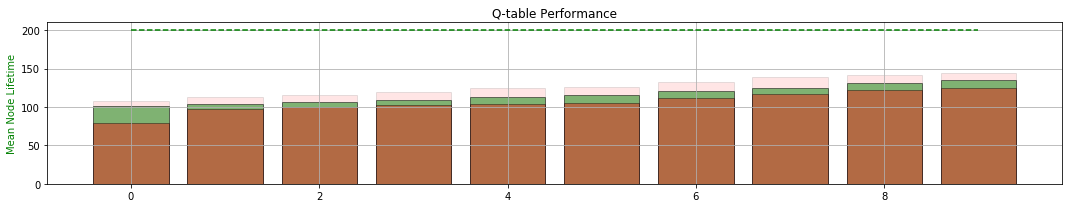

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 92.547	LOSS : 89.632	LOSS : 76.756	LOSS : 78.870	LOSS : 73.489	LOSS : 69.744	LOSS : 76.038	LOSS : 87.832	LOSS : 76.800	LOSS : 92.224	LOSS : 93.792	LOSS : 105.363	LOSS : 87.379	LOSS : 109.066	LOSS : 108.622	LOSS : 118.957	LOSS : 116.745	LOSS : 106.762	LOSS : 104.445	LOSS : 95.640	
Validating... MEAN TIME:  111.665
LOSS : 98.619	LOSS : 106.382	LOSS : 92.304	LOSS : 107.953	LOSS : 104.271	LOSS : 103.808	LOSS : 103.021	LOSS : 101.251	LOSS : 101.961	LOSS : 105.991	LOSS : 99.196	LOSS : 100.354	LOSS : 100.947	LOSS : 101.409	LOSS : 90.420	LOSS : 98.585	LOSS : 98.820	LOSS : 86.790	LOSS : 102.110	LOSS : 93.269	
Validating... MEAN TIME:  111.005
LOSS : 98.171	LOSS : 97.162	LOSS : 94.345	LOSS : 93.941	LOSS : 94.376	LOSS : 98.209	LOSS : 92.254	LOSS : 96.797	LOSS : 87.729	LOSS : 88.805	LOSS : 89.596	LOSS : 91.175	LOSS : 101.889	LOSS : 85.069	LOSS : 94.713	LOSS : 89.400	LOSS : 94.476	LOSS : 95.706	LOSS : 95.456	L

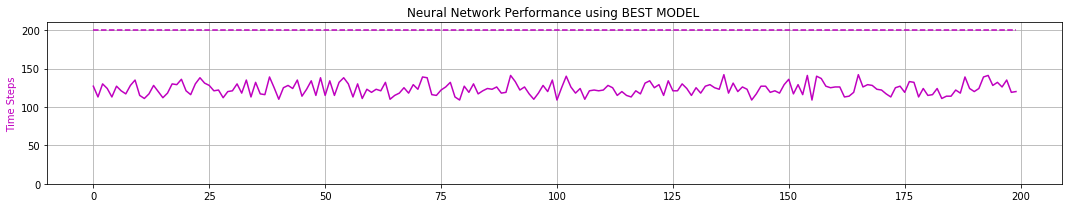

peak memory: 49126.78 MiB, increment: 43346.86 MiB
0 -max- [ 0.185  1.208  0.046  0.671  0.275]
0 -min- [-2.400 -3.114 -0.209 -1.682  0.225]

1 -max- [ 0.160  1.173  0.048  0.702  0.325]
1 -min- [-2.399 -3.066 -0.209 -1.673  0.275]

2 -max- [ 0.174  1.205  0.049  0.638  0.375]
2 -min- [-2.399 -3.129 -0.209 -1.670  0.326]

3 -max- [ 0.158  1.009  0.049  0.706  0.424]
3 -min- [-2.399 -2.920 -0.209 -1.477  0.375]

4 -max- [ 0.161  1.005  0.049  0.721  0.474]
4 -min- [-2.399 -2.896 -0.209 -1.454  0.425]

5 -max- [ 0.154  1.003  0.050  0.870  0.525]
5 -min- [-2.399 -2.788 -0.208 -1.468  0.475]

6 -max- [ 0.156  1.019  0.048  0.856  0.574]
6 -min- [-2.400 -2.743 -0.209 -1.363  0.525]

7 -max- [ 0.172  0.980  0.048  0.879  0.625]
7 -min- [-2.400 -2.708 -0.207 -1.459  0.576]

8 -max- [ 0.149  0.930  0.051  0.783  0.674]
8 -min- [-2.399 -2.759 -0.209 -1.363  0.627]

9 -max- [ 0.123  0.979  0.049  0.692  0.724]
9 -min- [-2.400 -2.617 -0.209 -1.458  0.675]

Quantization TIME:  0.39 minutes


ITER

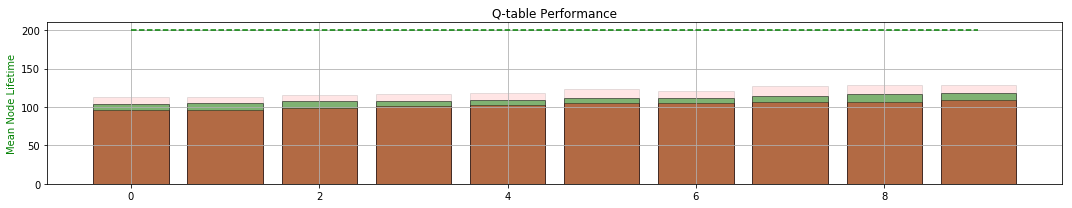

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 112.960	LOSS : 109.131	LOSS : 101.232	LOSS : 87.211	LOSS : 102.192	LOSS : 91.179	LOSS : 97.221	LOSS : 85.672	LOSS : 91.954	LOSS : 80.146	LOSS : 85.202	LOSS : 76.849	LOSS : 81.166	LOSS : 80.770	LOSS : 91.537	LOSS : 97.149	LOSS : 95.757	LOSS : 87.283	LOSS : 89.113	LOSS : 99.239	
Validating... MEAN TIME:  111.905
LOSS : 86.332	LOSS : 100.268	LOSS : 96.363	LOSS : 86.159	LOSS : 87.325	LOSS : 88.480	LOSS : 91.114	LOSS : 82.144	LOSS : 85.088	LOSS : 81.537	LOSS : 87.382	LOSS : 85.281	LOSS : 88.847	LOSS : 94.081	LOSS : 80.300	LOSS : 87.085	LOSS : 88.775	LOSS : 77.292	LOSS : 82.399	LOSS : 85.809	
Validating... MEAN TIME:  100.76
LOSS : 86.643	LOSS : 81.331	LOSS : 81.530	LOSS : 89.058	LOSS : 83.186	LOSS : 77.899	LOSS : 86.110	LOSS : 72.622	LOSS : 83.273	LOSS : 92.987	LOSS : 95.053	LOSS : 89.344	LOSS : 87.054	LOSS : 94.746	LOSS : 88.775	LOSS : 84.059	LOSS : 92.590	LOSS : 92.347	LOSS : 92.216	LOSS : 91.417	
Va

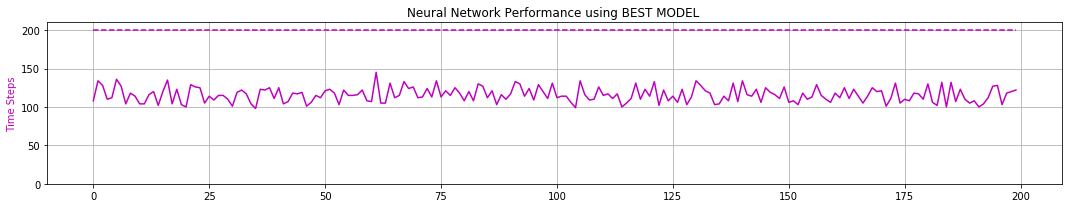

peak memory: 49171.24 MiB, increment: 43388.68 MiB
0 -max- [ 0.185  1.209  0.048  0.915  0.274]
0 -min- [-2.398 -2.992 -0.209 -1.681  0.225]

1 -max- [ 0.174  1.205  0.049  0.914  0.325]
1 -min- [-2.399 -3.150 -0.209 -1.673  0.275]

2 -max- [ 0.163  1.204  0.049  0.930  0.374]
2 -min- [-2.399 -3.101 -0.209 -1.680  0.325]

3 -max- [ 0.190  1.193  0.049  0.931  0.424]
3 -min- [-2.400 -2.957 -0.209 -1.655  0.375]

4 -max- [ 0.160  1.215  0.050  0.959  0.475]
4 -min- [-2.399 -3.086 -0.209 -1.676  0.425]

5 -max- [ 0.172  1.023  0.048  0.696  0.525]
5 -min- [-2.400 -2.957 -0.209 -1.493  0.477]

6 -max- [ 0.155  1.171  0.048  0.965  0.574]
6 -min- [-2.399 -2.971 -0.209 -1.686  0.525]

7 -max- [ 0.167  1.020  0.051  0.841  0.624]
7 -min- [-2.400 -2.882 -0.209 -1.365  0.576]

8 -max- [ 0.139  0.930  0.049  0.908  0.675]
8 -min- [-2.400 -2.958 -0.209 -1.354  0.625]

9 -max- [ 0.146  0.950  0.050  0.676  0.725]
9 -min- [-2.398 -2.795 -0.208 -1.363  0.675]

Quantization TIME:  0.4 minutes


ITERA

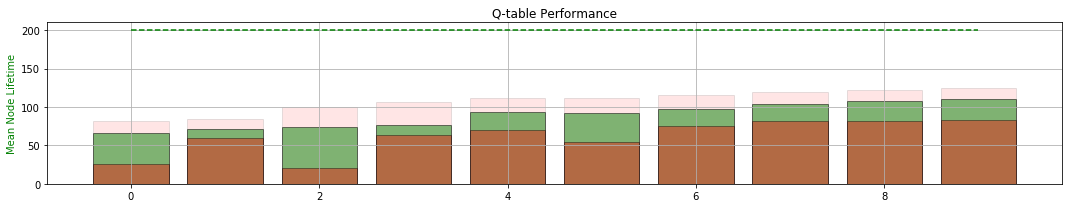

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 94.754	LOSS : 101.576	LOSS : 94.462	LOSS : 93.496	LOSS : 92.522	LOSS : 90.612	LOSS : 87.085	LOSS : 87.331	LOSS : 86.158	LOSS : 86.877	LOSS : 80.400	LOSS : 101.891	LOSS : 86.681	LOSS : 96.338	LOSS : 89.050	LOSS : 95.888	LOSS : 87.259	LOSS : 95.783	LOSS : 91.902	LOSS : 88.648	
Validating... MEAN TIME:  103.245
LOSS : 98.213	LOSS : 88.327	LOSS : 96.120	LOSS : 95.947	LOSS : 111.680	LOSS : 113.806	LOSS : 86.874	LOSS : 101.199	LOSS : 104.366	LOSS : 95.751	LOSS : 103.646	LOSS : 84.935	LOSS : 78.767	LOSS : 86.715	LOSS : 85.820	LOSS : 89.663	LOSS : 90.875	LOSS : 97.680	LOSS : 98.819	LOSS : 88.474	
Validating... MEAN TIME:  115.8
LOSS : 87.598	LOSS : 88.720	LOSS : 88.631	LOSS : 88.046	LOSS : 93.786	LOSS : 94.230	LOSS : 86.092	LOSS : 86.180	LOSS : 81.803	LOSS : 81.383	LOSS : 86.398	LOSS : 91.752	LOSS : 86.754	LOSS : 85.033	LOSS : 96.929	LOSS : 89.427	LOSS : 92.250	LOSS : 82.269	LOSS : 90.911	LOSS : 88.533	
V

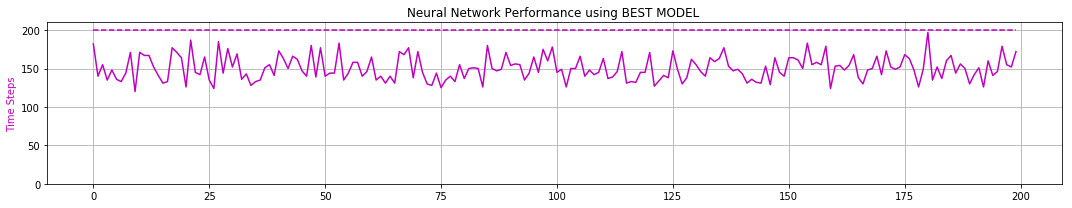

peak memory: 49234.06 MiB, increment: 43514.29 MiB
0 -max- [ 0.189  0.955  0.049  0.620  0.275]
0 -min- [-1.202 -2.243 -0.209 -1.468  0.226]

1 -max- [ 0.160  0.989  0.049  0.589  0.325]
1 -min- [-1.609 -2.587 -0.209 -1.366  0.275]

2 -max- [ 0.178  0.998  0.049  0.630  0.375]
2 -min- [-2.200 -3.106 -0.209 -1.361  0.325]

3 -max- [ 0.174  0.939  0.050  0.678  0.425]
3 -min- [-2.394 -3.270 -0.209 -1.354  0.375]

4 -max- [ 0.178  1.019  0.048  0.687  0.475]
4 -min- [-2.398 -3.343 -0.209 -1.363  0.425]

5 -max- [ 0.142  0.947  0.048  0.900  0.524]
5 -min- [-2.400 -3.261 -0.209 -1.363  0.476]

6 -max- [ 0.167  0.936  0.051  0.753  0.575]
6 -min- [-2.398 -3.329 -0.209 -1.531  0.526]

7 -max- [ 0.142  0.757  0.049  0.680  0.624]
7 -min- [-2.399 -3.314 -0.209 -1.181  0.575]

8 -max- [ 0.141  0.787  0.050  0.872  0.674]
8 -min- [-2.397 -3.261 -0.209 -1.294  0.625]

9 -max- [ 0.162  0.815  0.050  0.971  0.725]
9 -min- [-2.399 -3.163 -0.209 -1.159  0.675]

Quantization TIME:  0.41 minutes


ITER

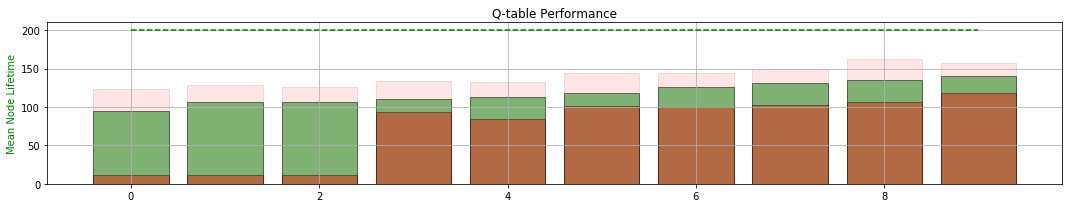

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 75.475	LOSS : 89.725	LOSS : 82.514	LOSS : 99.435	LOSS : 91.987	LOSS : 90.617	LOSS : 104.849	LOSS : 113.910	LOSS : 116.113	LOSS : 105.490	LOSS : 107.181	LOSS : 106.131	LOSS : 132.019	LOSS : 124.118	LOSS : 109.370	LOSS : 116.648	LOSS : 115.980	LOSS : 116.524	LOSS : 128.696	LOSS : 122.127	
Validating... MEAN TIME:  119.985
LOSS : 109.050	LOSS : 129.312	LOSS : 121.473	LOSS : 131.490	LOSS : 125.109	LOSS : 111.274	LOSS : 125.965	LOSS : 139.785	LOSS : 123.712	LOSS : 123.325	LOSS : 131.856	LOSS : 111.669	LOSS : 141.970	LOSS : 118.502	LOSS : 129.147	LOSS : 112.884	LOSS : 149.932	LOSS : 131.852	LOSS : 133.576	LOSS : 124.319	
Validating... MEAN TIME:  133.455
LOSS : 124.862	LOSS : 118.403	LOSS : 124.604	LOSS : 123.560	LOSS : 111.561	LOSS : 123.882	LOSS : 139.315	LOSS : 133.953	LOSS : 125.223	LOSS : 128.912	LOSS : 144.056	LOSS : 140.709	LOSS : 128.077	LOSS : 119.989	LOSS : 110.804	LOSS : 121.234	LOSS : 124.67

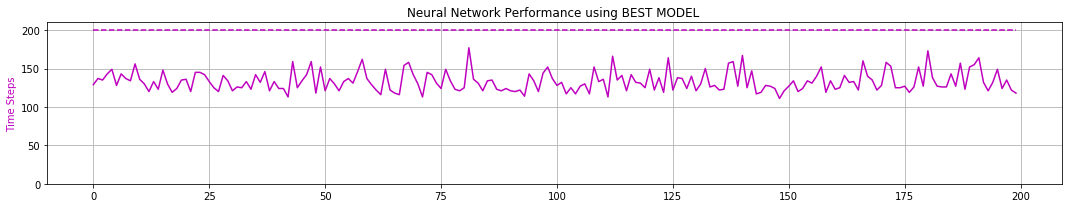

peak memory: 49500.35 MiB, increment: 43740.61 MiB
0 -max- [ 0.200  1.580  0.049  1.311  0.273]
0 -min- [-2.399 -3.086 -0.209 -2.299  0.225]

1 -max- [ 0.228  1.388  0.049  1.291  0.325]
1 -min- [-2.395 -3.168 -0.209 -2.034  0.275]

2 -max- [ 0.174  1.410  0.054  1.267  0.375]
2 -min- [-2.394 -2.938 -0.209 -1.979  0.325]

3 -max- [ 0.197  1.214  0.048  1.228  0.425]
3 -min- [-2.400 -2.987 -0.209 -1.683  0.375]

4 -max- [ 0.183  1.171  0.048  1.312  0.475]
4 -min- [-2.397 -2.960 -0.209 -1.686  0.425]

5 -max- [ 0.171  1.215  0.051  1.300  0.524]
5 -min- [-2.399 -2.945 -0.209 -1.681  0.475]

6 -max- [ 0.155  1.157  0.049  1.425  0.574]
6 -min- [-2.398 -2.977 -0.209 -1.733  0.525]

7 -max- [ 0.164  1.169  0.050  1.160  0.624]
7 -min- [-2.398 -2.946 -0.209 -1.664  0.575]

8 -max- [ 0.143  0.982  0.050  1.308  0.674]
8 -min- [-2.400 -2.964 -0.209 -1.422  0.625]

9 -max- [ 0.151  1.168  0.055  1.163  0.725]
9 -min- [-2.400 -2.983 -0.209 -1.616  0.675]

Quantization TIME:  0.41 minutes


ITER

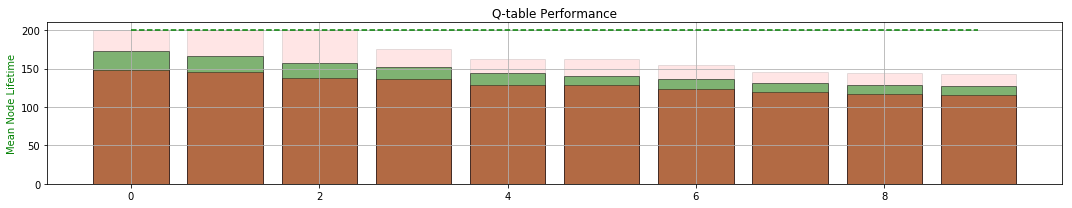

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 92.994	LOSS : 80.275	LOSS : 100.626	LOSS : 86.513	LOSS : 102.070	LOSS : 103.013	LOSS : 90.992	LOSS : 114.177	LOSS : 98.341	LOSS : 96.117	LOSS : 98.047	LOSS : 83.186	LOSS : 95.173	LOSS : 117.797	LOSS : 110.497	LOSS : 115.778	LOSS : 103.735	LOSS : 99.723	LOSS : 113.588	LOSS : 106.223	
Validating... MEAN TIME:  163.395
LOSS : 107.339	LOSS : 107.243	LOSS : 112.753	LOSS : 108.692	LOSS : 109.871	LOSS : 112.587	LOSS : 111.995	LOSS : 120.690	LOSS : 118.523	LOSS : 116.343	LOSS : 106.511	LOSS : 119.913	LOSS : 107.717	LOSS : 110.850	LOSS : 108.823	LOSS : 113.655	LOSS : 104.537	LOSS : 107.834	LOSS : 110.997	LOSS : 101.391	
Validating... MEAN TIME:  175.125
LOSS : 102.601	LOSS : 93.285	LOSS : 114.465	LOSS : 112.710	LOSS : 89.777	LOSS : 107.796	LOSS : 100.539	LOSS : 100.200	LOSS : 103.068	LOSS : 96.988	LOSS : 101.059	LOSS : 95.540	LOSS : 95.926	LOSS : 103.058	LOSS : 84.475	LOSS : 94.569	LOSS : 92.187	LOSS : 83.

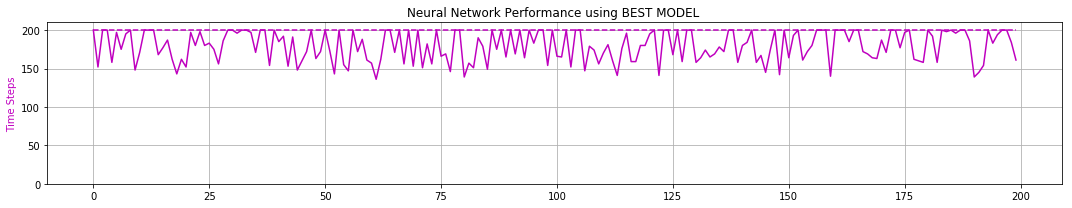

peak memory: 49460.19 MiB, increment: 43682.30 MiB
0 -max- [ 2.399  2.377  0.143  0.763  0.275]
0 -min- [-0.134 -0.436 -0.047 -0.686  0.226]

1 -max- [ 2.399  2.740  0.156  0.910  0.325]
1 -min- [-0.127 -0.603 -0.049 -1.156  0.275]

2 -max- [ 2.400  2.367  0.152  0.929  0.375]
2 -min- [-0.099 -0.439 -0.049 -0.678  0.325]

3 -max- [ 2.399  2.986  0.142  0.823  0.424]
3 -min- [-0.135 -0.601 -0.048 -1.387  0.376]

4 -max- [ 2.400  2.949  0.155  0.835  0.473]
4 -min- [-0.106 -0.574 -0.047 -1.257  0.425]

5 -max- [ 2.400  2.563  0.178  1.068  0.525]
5 -min- [-0.132 -0.610 -0.048 -0.688  0.475]

6 -max- [ 2.399  2.610  0.170  0.942  0.574]
6 -min- [-0.128 -0.636 -0.049 -0.681  0.526]

7 -max- [ 2.400  2.609  0.173  1.145  0.625]
7 -min- [-0.126 -0.733 -0.049 -0.683  0.576]

8 -max- [ 2.399  2.749  0.175  0.887  0.673]
8 -min- [-0.139 -0.633 -0.050 -0.671  0.625]

9 -max- [ 2.400  2.718  0.187  0.983  0.725]
9 -min- [-0.125 -0.632 -0.052 -0.675  0.675]

Quantization TIME:  0.42 minutes


ITER

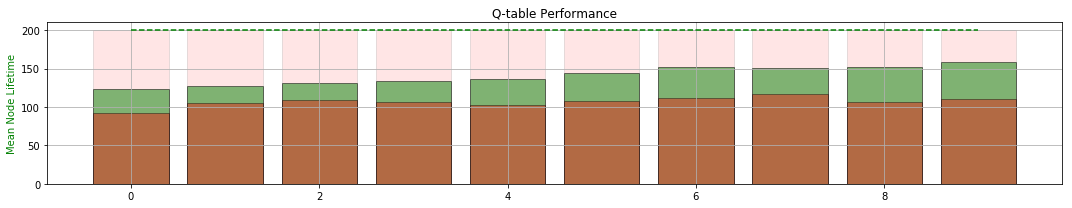

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 72.177	LOSS : 68.368	LOSS : 73.347	LOSS : 80.015	LOSS : 73.790	LOSS : 71.477	LOSS : 84.889	LOSS : 78.478	LOSS : 80.826	LOSS : 75.928	LOSS : 81.896	LOSS : 73.568	LOSS : 70.970	LOSS : 67.891	LOSS : 67.882	LOSS : 70.880	LOSS : 68.771	LOSS : 65.714	LOSS : 68.813	LOSS : 68.322	
Validating... MEAN TIME:  161.31
LOSS : 66.749	LOSS : 67.819	LOSS : 70.303	LOSS : 66.491	LOSS : 64.374	LOSS : 76.340	LOSS : 58.567	LOSS : 68.356	LOSS : 64.178	LOSS : 65.942	LOSS : 65.562	LOSS : 76.616	LOSS : 64.299	LOSS : 59.688	LOSS : 52.602	LOSS : 57.894	LOSS : 60.458	LOSS : 57.869	LOSS : 60.153	LOSS : 61.613	
Validating... MEAN TIME:  168.84
LOSS : 54.864	LOSS : 59.916	LOSS : 66.855	LOSS : 65.730	LOSS : 49.868	LOSS : 60.384	LOSS : 59.909	LOSS : 62.839	LOSS : 67.081	LOSS : 62.251	LOSS : 62.852	LOSS : 59.869	LOSS : 48.998	LOSS : 54.239	LOSS : 55.039	LOSS : 56.361	LOSS : 59.983	LOSS : 51.821	LOSS : 61.180	LOSS : 56.601	
Validati

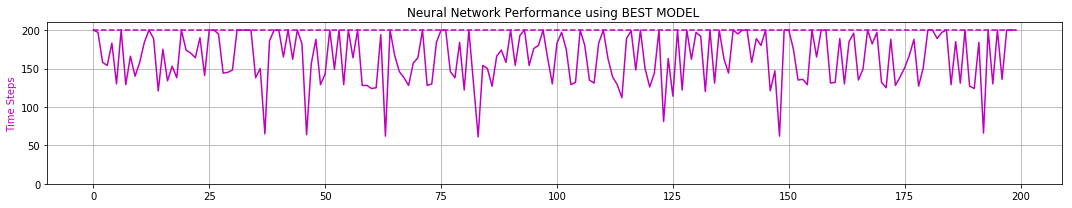

peak memory: 49533.61 MiB, increment: 43746.02 MiB
0 -max- [ 0.145  0.771  0.050  1.005  0.274]
0 -min- [-1.687 -2.219 -0.209 -1.166  0.227]

1 -max- [ 1.464  1.878  0.208  0.971  0.325]
1 -min- [-2.351 -2.927 -0.209 -1.075  0.276]

2 -max- [ 1.277  1.686  0.168  0.963  0.375]
2 -min- [-2.381 -2.940 -0.209 -1.180  0.327]

3 -max- [ 1.397  1.879  0.207  1.029  0.424]
3 -min- [-2.395 -2.943 -0.209 -1.072  0.375]

4 -max- [ 1.490  1.861  0.208  0.974  0.474]
4 -min- [-2.118 -2.603 -0.209 -1.140  0.425]

5 -max- [ 1.441  1.823  0.206  0.920  0.524]
5 -min- [-2.319 -2.753 -0.209 -1.102  0.476]

6 -max- [ 1.356  1.690  0.207  1.039  0.575]
6 -min- [-2.381 -2.934 -0.209 -1.152  0.525]

7 -max- [ 1.392  1.867  0.208  1.037  0.624]
7 -min- [-2.399 -2.972 -0.209 -1.145  0.575]

8 -max- [ 1.283  1.825  0.207  1.021  0.673]
8 -min- [-2.397 -2.938 -0.209 -1.158  0.626]

9 -max- [ 1.244  1.830  0.209  1.047  0.725]
9 -min- [-2.391 -2.960 -0.209 -1.115  0.675]

Quantization TIME:  0.41 minutes


ITER

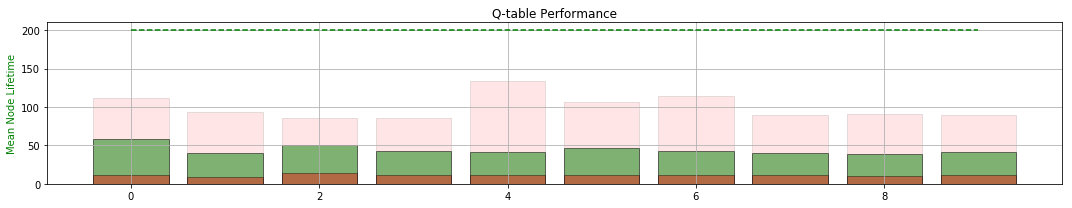

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 116.958	LOSS : 119.841	LOSS : 128.005	LOSS : 129.746	LOSS : 144.837	LOSS : 131.351	LOSS : 130.732	LOSS : 126.812	LOSS : 120.237	LOSS : 104.262	LOSS : 113.372	LOSS : 114.668	LOSS : 116.128	LOSS : 115.649	LOSS : 105.692	LOSS : 113.106	LOSS : 111.942	LOSS : 117.653	LOSS : 110.996	LOSS : 113.597	
Validating... MEAN TIME:  135.45
LOSS : 104.827	LOSS : 117.598	LOSS : 118.462	LOSS : 117.962	LOSS : 123.605	LOSS : 118.921	LOSS : 115.694	LOSS : 108.779	LOSS : 125.669	LOSS : 116.656	LOSS : 112.776	LOSS : 99.253	LOSS : 102.033	LOSS : 113.943	LOSS : 110.232	LOSS : 105.395	LOSS : 111.498	LOSS : 104.444	LOSS : 94.656	LOSS : 96.956	
Validating... MEAN TIME:  136.965
LOSS : 101.388	LOSS : 106.689	LOSS : 104.953	LOSS : 96.676	LOSS : 95.725	LOSS : 89.954	LOSS : 96.491	LOSS : 97.337	LOSS : 104.985	LOSS : 102.803	LOSS : 94.240	LOSS : 102.307	LOSS : 101.040	LOSS : 108.915	LOSS : 103.763	LOSS : 103.492	LOSS : 105.094	LO

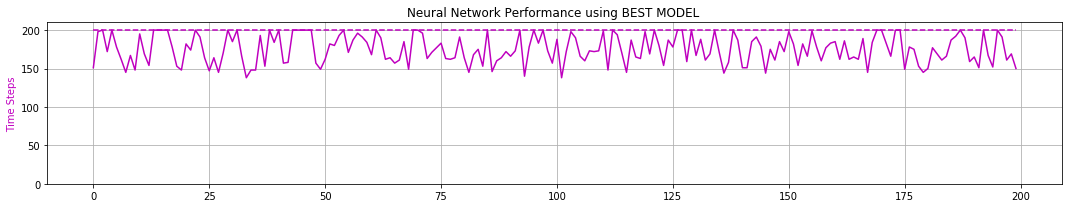

peak memory: 49426.91 MiB, increment: 43703.92 MiB
0 -max- [ 0.235  1.027  0.107  1.593  0.275]
0 -min- [-2.352 -2.875 -0.209 -1.985  0.226]

1 -max- [ 0.195  1.168  0.117  1.540  0.325]
1 -min- [-1.334 -2.079 -0.209 -1.972  0.275]

2 -max- [ 0.221  1.125  0.123  1.327  0.375]
2 -min- [-1.267 -1.924 -0.209 -2.071  0.325]

3 -max- [ 0.197  1.043  0.139  1.487  0.424]
3 -min- [-1.169 -1.922 -0.209 -2.093  0.375]

4 -max- [ 0.204  1.027  0.110  1.344  0.473]
4 -min- [-2.393 -2.887 -0.209 -2.103  0.426]

5 -max- [ 0.209  1.025  0.131  1.334  0.523]
5 -min- [-1.003 -1.925 -0.209 -2.211  0.475]

6 -max- [ 0.203  1.026  0.133  1.536  0.575]
6 -min- [-1.802 -2.396 -0.209 -2.351  0.527]

7 -max- [ 0.218  1.408  0.194  1.561  0.625]
7 -min- [-1.143 -2.019 -0.209 -2.353  0.575]

8 -max- [ 0.207  1.148  0.150  1.452  0.674]
8 -min- [-0.980 -1.923 -0.209 -2.270  0.625]

9 -max- [ 0.194  1.157  0.137  1.335  0.725]
9 -min- [-0.996 -1.908 -0.209 -2.289  0.675]

Quantization TIME:  0.41 minutes


ITER

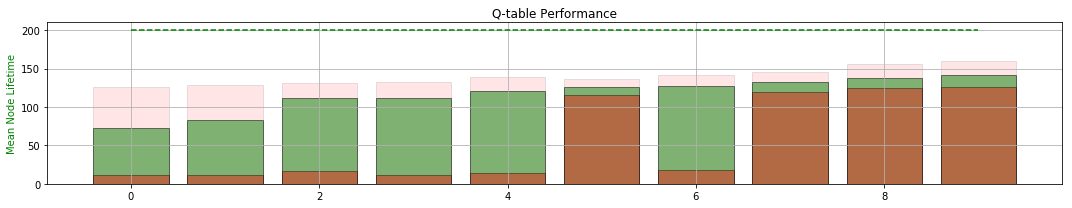

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 296.523	LOSS : 297.323	LOSS : 252.524	LOSS : 220.193	LOSS : 209.782	LOSS : 222.194	LOSS : 199.740	LOSS : 186.302	LOSS : 175.625	LOSS : 173.897	LOSS : 176.611	LOSS : 154.049	LOSS : 155.429	LOSS : 163.907	LOSS : 152.710	LOSS : 142.983	LOSS : 155.823	LOSS : 145.077	LOSS : 140.485	LOSS : 155.116	
Validating... MEAN TIME:  134.47
LOSS : 151.451	LOSS : 148.413	LOSS : 146.653	LOSS : 155.967	LOSS : 156.947	LOSS : 148.324	LOSS : 158.848	LOSS : 154.873	LOSS : 154.588	LOSS : 163.768	LOSS : 160.063	LOSS : 161.075	LOSS : 155.543	LOSS : 153.924	LOSS : 147.043	LOSS : 162.945	LOSS : 152.614	LOSS : 144.033	LOSS : 142.658	LOSS : 154.464	
Validating... MEAN TIME:  139.715
LOSS : 148.498	LOSS : 147.884	LOSS : 137.847	LOSS : 139.565	LOSS : 153.399	LOSS : 158.628	LOSS : 146.967	LOSS : 149.307	LOSS : 156.959	LOSS : 137.443	LOSS : 140.468	LOSS : 142.312	LOSS : 141.620	LOSS : 135.892	LOSS : 141.142	LOSS : 145.866	LOSS : 1

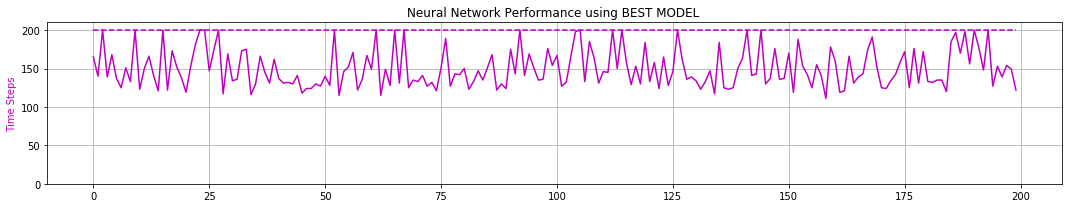

peak memory: 49506.86 MiB, increment: 43744.45 MiB
0 -max- [ 0.199  1.142  0.093  1.216  0.275]
0 -min- [-2.400 -2.243 -0.209 -1.658  0.226]

1 -max- [ 0.217  1.125  0.078  1.283  0.325]
1 -min- [-2.399 -2.374 -0.209 -1.657  0.276]

2 -max- [ 0.189  0.829  0.068  1.086  0.373]
2 -min- [-2.399 -2.250 -0.209 -1.337  0.325]

3 -max- [ 0.199  1.010  0.055  1.035  0.425]
3 -min- [-2.400 -2.099 -0.209 -1.412  0.376]

4 -max- [ 0.188  0.961  0.066  1.174  0.475]
4 -min- [-2.400 -2.272 -0.209 -1.441  0.426]

5 -max- [ 0.187  1.006  0.087  1.048  0.524]
5 -min- [-2.400 -2.249 -0.209 -1.389  0.475]

6 -max- [ 0.177  0.824  0.084  1.307  0.575]
6 -min- [-2.400 -2.251 -0.209 -1.551  0.527]

7 -max- [ 0.178  0.950  0.073  1.147  0.624]
7 -min- [-2.399 -2.098 -0.209 -1.393  0.575]

8 -max- [ 0.175  0.812  0.084  1.270  0.674]
8 -min- [-2.400 -2.091 -0.209 -1.327  0.626]

9 -max- [ 0.176  0.816  0.093  1.212  0.724]
9 -min- [-2.400 -2.101 -0.209 -1.328  0.678]

Quantization TIME:  0.42 minutes


ITER

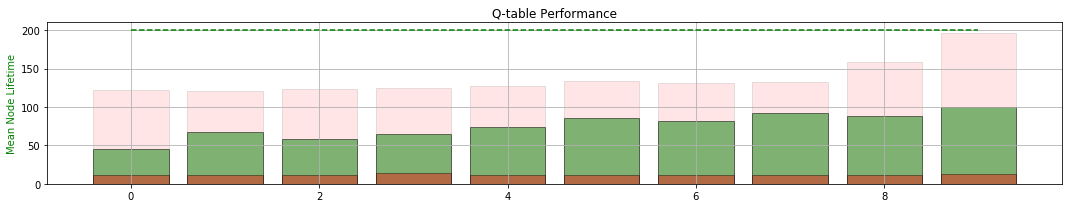

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 154.709	LOSS : 139.067	LOSS : 139.484	LOSS : 128.235	LOSS : 121.563	LOSS : 118.100	LOSS : 108.234	LOSS : 125.481	LOSS : 117.240	LOSS : 108.730	LOSS : 122.800	LOSS : 115.298	LOSS : 115.600	LOSS : 108.433	LOSS : 122.556	LOSS : 121.180	LOSS : 116.910	LOSS : 111.918	LOSS : 108.865	LOSS : 108.033	
Validating... MEAN TIME:  81.99
LOSS : 121.243	LOSS : 106.189	LOSS : 117.001	LOSS : 120.734	LOSS : 117.536	LOSS : 107.990	LOSS : 117.493	LOSS : 115.010	LOSS : 117.823	LOSS : 121.019	LOSS : 121.906	LOSS : 113.449	LOSS : 115.759	LOSS : 130.752	LOSS : 112.858	LOSS : 126.147	LOSS : 115.228	LOSS : 122.357	LOSS : 121.429	LOSS : 124.252	
Validating... MEAN TIME:  131.165
LOSS : 115.538	LOSS : 112.762	LOSS : 122.333	LOSS : 122.490	LOSS : 120.271	LOSS : 113.065	LOSS : 112.664	LOSS : 126.692	LOSS : 115.254	LOSS : 120.043	LOSS : 118.226	LOSS : 119.186	LOSS : 123.451	LOSS : 122.188	LOSS : 110.783	LOSS : 120.302	LOSS : 11

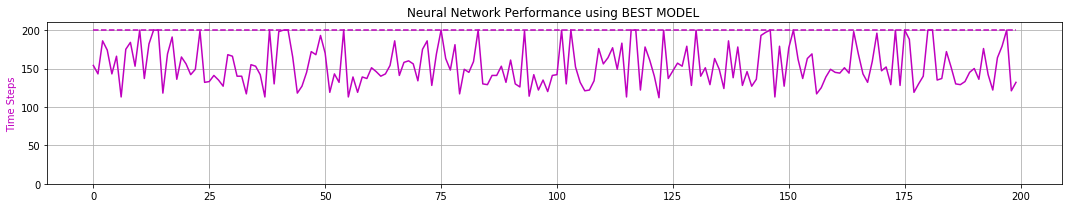

peak memory: 48977.46 MiB, increment: 43215.07 MiB
0 -max- [ 0.220  1.171  0.091  1.030  0.274]
0 -min- [-2.400 -2.801 -0.209 -1.640  0.225]

1 -max- [ 0.197  0.802  0.069  0.995  0.324]
1 -min- [-2.400 -2.978 -0.209 -1.408  0.275]

2 -max- [ 0.204  0.831  0.066  1.276  0.374]
2 -min- [-2.400 -2.960 -0.209 -1.548  0.325]

3 -max- [ 0.221  0.833  0.075  1.276  0.425]
3 -min- [-2.398 -2.796 -0.209 -1.437  0.376]

4 -max- [ 0.202  0.828  0.071  1.273  0.475]
4 -min- [-2.400 -2.907 -0.209 -1.564  0.425]

5 -max- [ 0.191  0.821  0.090  1.281  0.525]
5 -min- [-2.399 -2.808 -0.209 -1.635  0.475]

6 -max- [ 0.191  0.830  0.090  1.229  0.575]
6 -min- [-2.399 -2.800 -0.209 -1.589  0.525]

7 -max- [ 0.163  0.824  0.104  1.271  0.625]
7 -min- [-2.399 -2.959 -0.209 -1.620  0.575]

8 -max- [ 0.163  0.824  0.141  1.245  0.675]
8 -min- [-2.400 -2.915 -0.209 -1.675  0.625]

9 -max- [ 0.215  0.795  0.139  1.273  0.725]
9 -min- [-2.399 -2.801 -0.209 -1.586  0.675]

Quantization TIME:  0.42 minutes


ITER

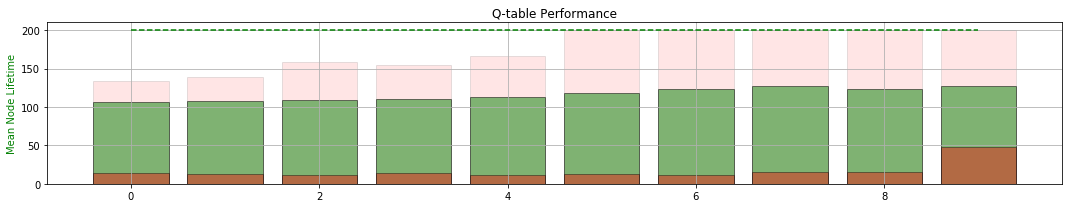

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 105.370	LOSS : 109.653	LOSS : 122.865	LOSS : 118.519	LOSS : 112.033	LOSS : 114.743	LOSS : 120.799	LOSS : 112.403	LOSS : 117.708	LOSS : 122.317	LOSS : 122.575	LOSS : 128.040	LOSS : 129.241	LOSS : 110.923	LOSS : 119.088	LOSS : 123.437	LOSS : 117.348	LOSS : 108.168	LOSS : 113.336	LOSS : 108.896	
Validating... MEAN TIME:  196.9
LOSS : 116.936	LOSS : 110.793	LOSS : 126.369	LOSS : 101.994	LOSS : 112.567	LOSS : 106.071	LOSS : 103.332	LOSS : 108.442	LOSS : 112.562	LOSS : 114.800	LOSS : 101.964	LOSS : 102.842	LOSS : 106.552	LOSS : 108.779	LOSS : 105.410	LOSS : 104.074	LOSS : 102.160	LOSS : 103.172	LOSS : 99.043	LOSS : 94.337	
Validating... MEAN TIME:  197.065
LOSS : 109.052	LOSS : 105.844	LOSS : 94.750	LOSS : 113.716	LOSS : 115.680	LOSS : 106.388	LOSS : 110.804	LOSS : 112.969	LOSS : 111.027	LOSS : 109.221	LOSS : 100.638	LOSS : 102.984	LOSS : 104.628	LOSS : 99.387	LOSS : 103.399	LOSS : 105.127	LOSS : 108.69

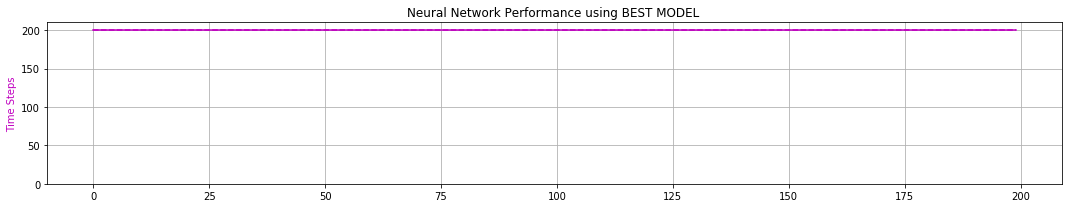

peak memory: 49339.10 MiB, increment: 43560.53 MiB
0 -max- [ 0.130  0.826  0.049  1.003  0.275]
0 -min- [-2.400 -2.921 -0.209 -1.350  0.225]

1 -max- [ 0.131  1.143  0.050  0.998  0.325]
1 -min- [-2.400 -2.960 -0.209 -1.604  0.275]

2 -max- [ 0.150  0.830  0.052  1.014  0.375]
2 -min- [-2.400 -2.782 -0.209 -1.245  0.325]

3 -max- [ 0.119  0.817  0.049  1.111  0.425]
3 -min- [-2.400 -2.788 -0.209 -1.332  0.375]

4 -max- [ 0.101  0.824  0.054  0.951  0.474]
4 -min- [-2.400 -2.791 -0.208 -1.389  0.426]

5 -max- [ 1.140  1.322  0.164  0.995  0.524]
5 -min- [-2.400 -2.780 -0.208 -1.656  0.475]

6 -max- [ 0.255  0.649  0.071  0.988  0.575]
6 -min- [-2.400 -2.765 -0.209 -1.377  0.525]

7 -max- [ 0.470  0.789  0.080  0.993  0.625]
7 -min- [-2.400 -2.949 -0.209 -1.409  0.575]

8 -max- [ 1.563  1.801  0.208  1.019  0.675]
8 -min- [-2.400 -2.787 -0.209 -1.666  0.625]

9 -max- [ 1.527  1.873  0.207  1.003  0.724]
9 -min- [-2.399 -2.910 -0.208 -1.345  0.675]

Quantization TIME:  0.4 minutes


ITERA

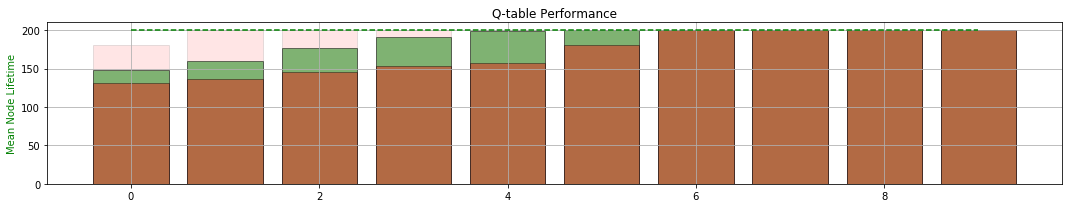

In [20]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    q_table_list = [node_q_table]* NO_OF_NODES
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)
    
    print("TOTAL EXPERIENCE GENERATED:   {:d}".format(EXP_GEN.astype(int)))

    print("SMALLEST TIMESTEP: {:d}".format(node_time_rec.min().astype(int)))
    print("LARGEST  TIMESTEP: {:d}".format(node_time_rec.max().astype(int)))

    print("TOTAL SERIAL TIMESTEPS:   {:d}".format(total_serial_timesteps.astype(int)))
    print("TOTAL PARALLEL TIMESTEPS: {:d}".format(total_parallel_timesteps.astype(int)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_avg_time[node_avg_time >= 195].shape[0] > NO_OF_NODES/2:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            v_env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
            v_xtra = [v_env.length]
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()
                s = np.append(s, v_xtra)
                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)
                    s_ = np.append(s_, v_xtra)
                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                nn_level_up_metric = clamp(0, nn_level_up_metric, 195)
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
        Xtra = [env.length]
        time_step = 0
        s = env.reset()
        s = np.append(s, Xtra)

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            s_ = np.append(s_, Xtra)

            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        
    ##################################################################
    
    # CREATE ONE LARGE Q-TABLES FROM WHICH THE NODES STRIP
    ##################################################################
        
#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN * NO_OF_NODES  ])
    
    start = timeit.default_timer()
    # GET Q-VALUES 
    %memit node_q_table = best_dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN, LO_GRAIN*NO_OF_NODES).astype(np.intp)

    # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
    stop = timeit.default_timer()

#     ##################################################################
    
#     # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
#     ##################################################################
    
    for node_id in range(NO_OF_NODES):
# #         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
# #         ###############################################
#         [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#          C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
# #         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
# #         node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
# #                                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
# #         # CREATE STATE COMBINATIONS
# #         ###############################################

#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
#         ###############################################
#     start = timeit.default_timer()
#     # GET Q-VALUES 
#     %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

#     # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
#         #############################################################################################################################################
#     stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()

In [21]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  3038.0
Total Serial Timesteps   :  1992531.0
Speed-up                 :  655.87


In [22]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [23]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))

  9295 SUCCESS 131  17    3038    1992531     655.87
